In [892]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime as dt

In [149]:
! ls ../datasets/air-quality-uci/

AirQualityUCI.csv  AirQualityUCI.xlsx


# References
https://machinelearningmastery.com/multi-output-regression-models-with-python/

In [980]:
# Pre-processing

# Import data
file_name = "../datasets/air-quality-uci/AirQualityUCI.csv"
df = pd.read_csv(file_name, sep=';',  parse_dates=[['Date', 'Time']])

# Clean-up column names
df.columns = df.columns.str.replace('(', '_').str.replace(')', '')

# Drop empty rows at the end
df = df[:-114] 

# Drop empty columns at the end
df = df.drop(df.columns[14:16], axis=1)

# Fix commas in column values and column data types
df['CO_GT'] = pd.to_numeric(df['CO_GT'].str.replace(',', '.'))
df['C6H6_GT'] =  pd.to_numeric(df['C6H6_GT'].str.replace(',', '.'))
df['T'] = pd.to_numeric(df['T'].str.replace(',', '.'))
df['RH'] = pd.to_numeric(df['RH'].str.replace(',', '.'))
df['AH'] = pd.to_numeric(df['AH'].str.replace(',', '.'))

# Fix date time column and set as index
df['Date_Time'] = pd.to_datetime(df.Date_Time, format='%d/%m/%Y %H.%M.%S')
df['Date'] = pd.to_datetime(df.Date_Time, format='%d/%m/%Y')
df['Date'] = df['Date'].dt.normalize()

df = df.set_index('Date_Time')

# Reorder columns
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

# Missing values are encoded as -200 in the dataset, replace them with NaN
df = df.replace(-200, np.NaN)


In [1075]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          9357 non-null   datetime64[ns]
 1   CO_GT         7674 non-null   float64       
 2   PT08.S1_CO    9357 non-null   float64       
 3   NMHC_GT       914 non-null    float64       
 4   C6H6_GT       8991 non-null   float64       
 5   PT08.S2_NMHC  9357 non-null   float64       
 6   NOx_GT        7718 non-null   float64       
 7   PT08.S3_NOx   9357 non-null   float64       
 8   NO2_GT        7715 non-null   float64       
 9   PT08.S4_NO2   9357 non-null   float64       
 10  PT08.S5_O3    9357 non-null   float64       
 11  T             9357 non-null   float64       
 12  RH            9357 non-null   float64       
 13  AH            9357 non-null   float64       
 14  DOW           9357 non-null   datetime64[ns]
dtypes:

In [981]:
df.columns

Index(['Date', 'CO_GT', 'PT08.S1_CO', 'NMHC_GT', 'C6H6_GT', 'PT08.S2_NMHC',
       'NOx_GT', 'PT08.S3_NOx', 'NO2_GT', 'PT08.S4_NO2', 'PT08.S5_O3', 'T',
       'RH', 'AH'],
      dtype='object')

In [1093]:
features = ['PT08.S1_CO', 'PT08.S2_NMHC','PT08.S3_NOx', 'PT08.S4_NO2', 'PT08.S5_O3','T','RH', 'AH']
targets = ['CO_GT', 'C6H6_GT', 'NOx_GT', 'NO2_GT']

In [983]:
# Fill missing values with daily averages
# This doesn't completely fill the missing NaN's because some grouped days have all NaN's
'''
for f in features:
    #print(df[f].isna().sum())
    df[f].fillna(df[f].groupby(df.Date).transform('mean'), inplace=True)
    #print(df[f].isna().sum())
'''

"\nfor f in features:\n    #print(df[f].isna().sum())\n    df[f].fillna(df[f].groupby(df.Date).transform('mean'), inplace=True)\n    #print(df[f].isna().sum())\n"

In [984]:
# Fill missing values with daily averages
grouped = df[features].groupby(df.Date).mean()
grouped = grouped.fillna(method='ffill')

for f in features:
    #print(df[f].isna().sum())
    df[f].fillna(df.Date.map(grouped[f]), inplace=True)
    #print(df[f].isna().sum())

In [985]:
#df.info()

In [1039]:
# Detect outliers based on z-score
for f in features:
    z = np.abs(stats.zscore(df[f]))
    print(f, ": ", df[f][(z > 3)].count())


PT08.S1_CO :  65
PT08.S2_NMHC :  40
PT08.S3_NOx :  112
PT08.S4_NO2 :  43
PT08.S5_O3 :  37
T :  0
RH :  0
AH :  1


In [1057]:
# Detect outliers based on inter-quantile range
for f in features:
    Q1 = df[f].quantile(0.25)
    Q3 = df[f].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[f][(df[f] < (Q1 - 1.5 * IQR)) | (df[f] > (Q3 + 1.5 * IQR))].count()
    print(f, ": ", outliers)


PT08.S1_CO :  131
PT08.S2_NMHC :  61
PT08.S3_NOx :  252
PT08.S4_NO2 :  112
PT08.S5_O3 :  95
T :  2
RH :  0
AH :  1


In [1077]:
# 
df_filtered = df
z = np.abs(stats.zscore(df_filtered['PT08.S2_NMHC']))
df_filtered = df_filtered['PT08.S2_NMHC'][(z <= 3)]
print(df_filtered.shape)

(9317,)


In [1083]:
# 
df_filtered = df
for f in features:
    z = np.abs(stats.zscore(df_filtered[f]))
    #df_filtered = df_filtered[f][(z <= 3)]
    print(type(z))
    print(f, ": ", df_filtered[f][(z <= 3)].count())
    print(df_filtered.shape)

<class 'numpy.ndarray'>
PT08.S1_CO :  9292
(9357, 15)
<class 'numpy.ndarray'>
PT08.S2_NMHC :  9317
(9357, 15)
<class 'numpy.ndarray'>
PT08.S3_NOx :  9245
(9357, 15)
<class 'numpy.ndarray'>
PT08.S4_NO2 :  9314
(9357, 15)
<class 'numpy.ndarray'>
PT08.S5_O3 :  9320
(9357, 15)
<class 'numpy.ndarray'>
T :  9357
(9357, 15)
<class 'numpy.ndarray'>
RH :  9357
(9357, 15)
<class 'numpy.ndarray'>
AH :  9356
(9357, 15)


In [ ]:
boston_df_o = boston_df_o[(z < 3).all(axis=1)]

In [1094]:
df_X = df[features]
df_y = df[targets]

In [1087]:
df_X = df[features]
z = np.abs(stats.zscore(df_X))
print(z)
print(df_X.shape)
df_X = df_X[(z < 3).all(axis=1)]
print(df_X.shape)

[[1.20938053 0.40921076 0.87060465 ... 0.5170796  0.0225758  0.64557946]
 [0.893387   0.06468089 1.33624936 ... 0.55104233 0.0923439  0.72561235]
 [1.404553   0.00410421 1.20208055 ... 0.70953506 0.27393865 0.66441073]
 ...
 [0.19634247 0.47357348 0.91699752 ... 0.98860136 1.80166249 0.93597744]
 [0.44958547 0.08739715 0.5263295  ... 1.14709409 2.08073492 1.24991451]
 [0.13359195 0.4129968  0.7157443  ... 1.16973591 2.10399095 1.27741807]]
(9357, 8)
(9135, 8)


In [1103]:

df_y = df_y.dropna(subset=targets)
df_y.shape

(6941, 4)

In [1109]:
merged = pd.merge(df_X, df_y, left_index=True, right_index=True)
merged['PT08.S1_CO'].describe()

count    6941.000000
mean     1119.913269
std       218.733754
min       647.000000
25%       956.000000
50%      1085.000000
75%      1254.000000
max      2040.000000
Name: PT08.S1_CO, dtype: float64

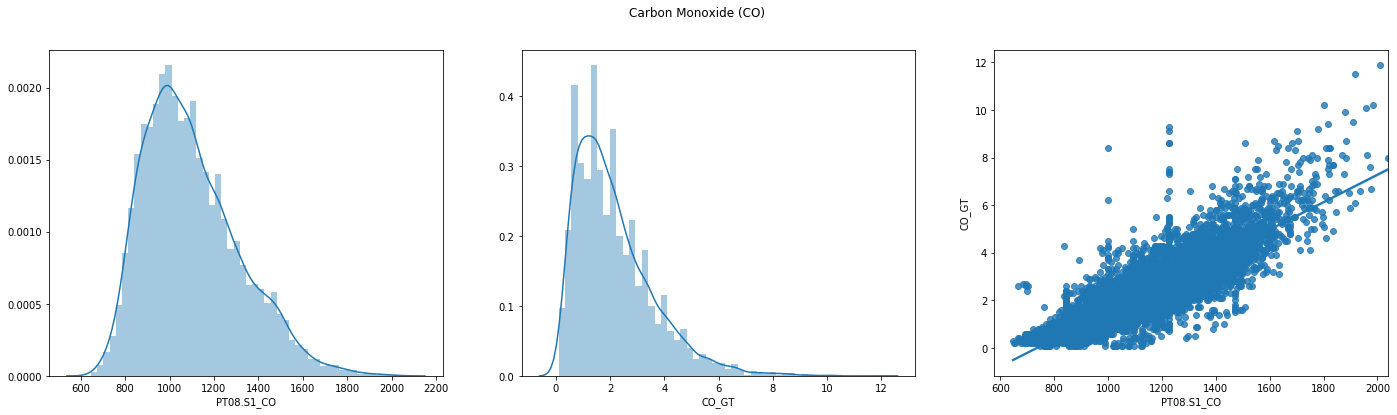

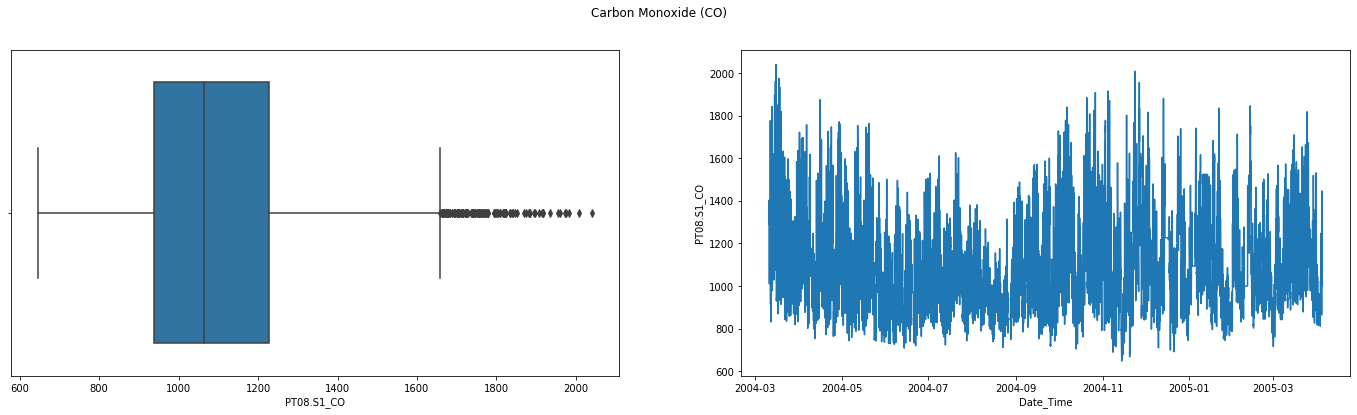

In [1018]:
# Carbon Monoxide (CO) data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle('Carbon Monoxide (CO)')
sns.distplot(df['PT08.S1_CO'], norm_hist=False, kde=True, ax=ax1) 
sns.distplot(df['CO_GT'], norm_hist=False, kde=True, ax=ax2)   
sns.regplot(x="PT08.S1_CO", y="CO_GT", data=df, ax=ax3)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
fig.suptitle('Carbon Monoxide (CO)')
sns.boxplot(x="PT08.S1_CO", data=df, ax=ax1)
sns.lineplot(x=df.index, y="PT08.S1_CO", data=df, ax=ax2)

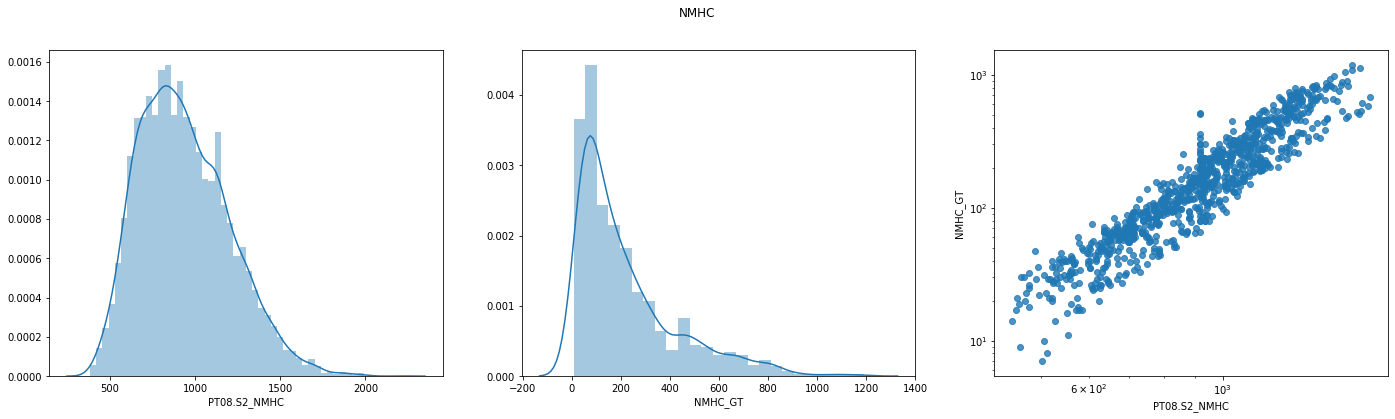

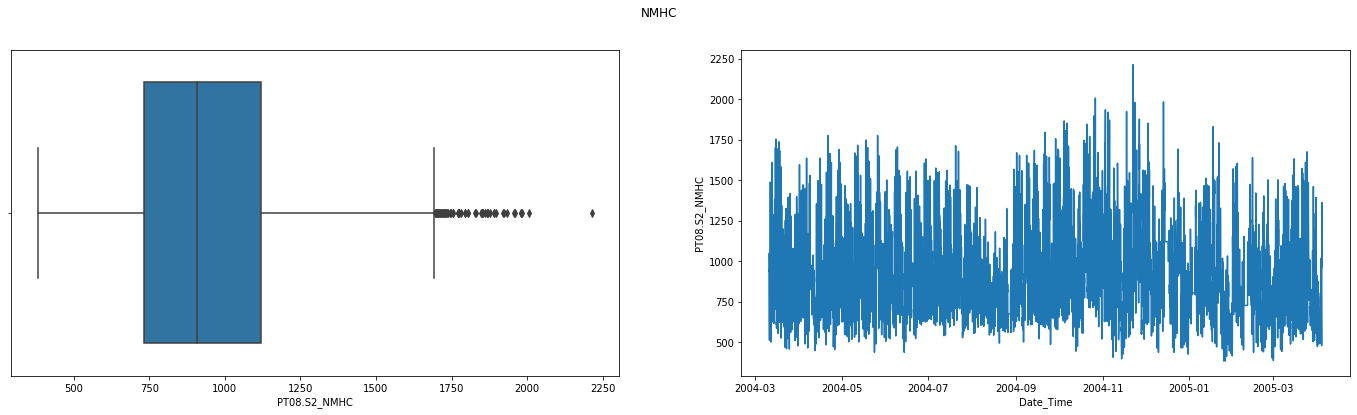

In [1020]:
# Non-Methane Hydrocarbons data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle('NMHC')
sns.distplot(df['PT08.S2_NMHC'], norm_hist=False, kde=True, ax=ax1) 
sns.distplot(df['NMHC_GT'], norm_hist=False, kde=True, ax=ax2)   
sns.regplot(x="PT08.S2_NMHC", y="NMHC_GT", fit_reg=False, data=df, ax=ax3)
ax3.set(xscale='log', yscale='log')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
fig.suptitle('NMHC')
sns.boxplot(x="PT08.S2_NMHC", data=df, ax=ax1)
sns.lineplot(x=df.index, y="PT08.S2_NMHC", data=df, ax=ax2)

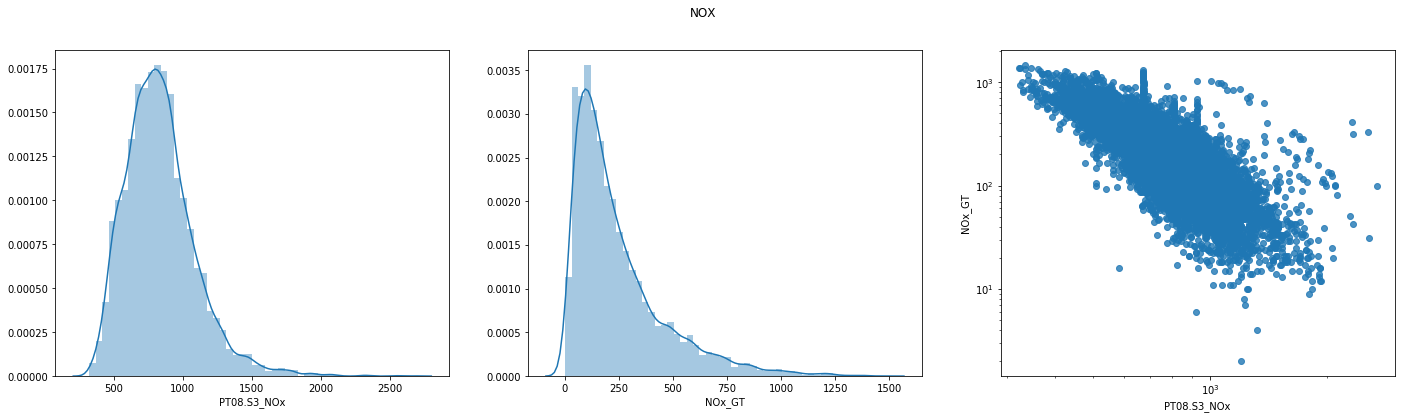

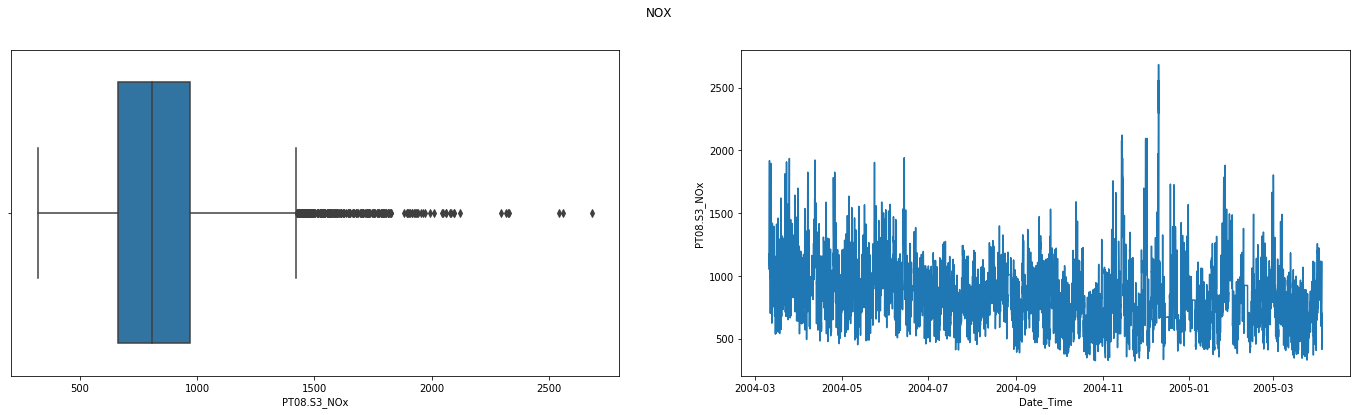

In [1019]:
# NOX data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle('NOX')
sns.distplot(df['PT08.S3_NOx'], norm_hist=False, kde=True, ax=ax1) 
sns.distplot(df['NOx_GT'], norm_hist=False, kde=True, ax=ax2)   
sns.regplot(x="PT08.S3_NOx", y="NOx_GT", fit_reg=False, data=df, ax=ax3)
ax3.set(xscale='log', yscale='log')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
fig.suptitle('NOX')
sns.boxplot(x="PT08.S3_NOx", data=df, ax=ax1)
sns.lineplot(x=df.index, y="PT08.S3_NOx", data=df, ax=ax2)

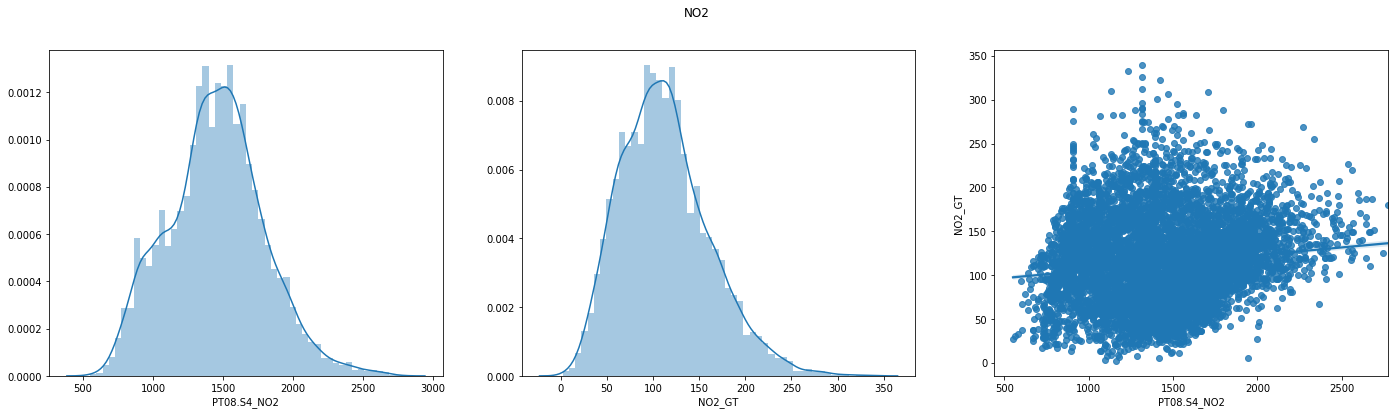

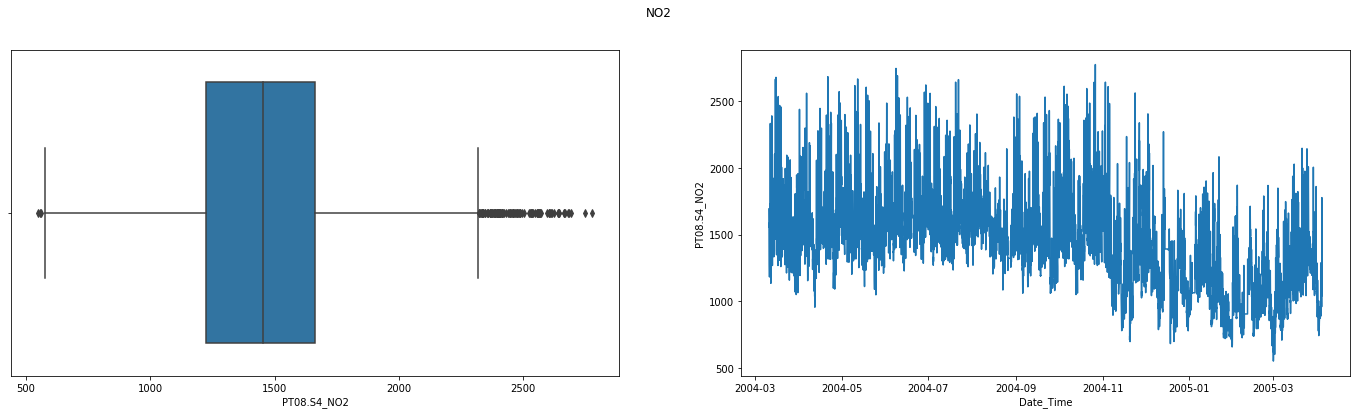

In [1023]:
# NO2 data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle('NO2')
sns.distplot(df['PT08.S4_NO2'], norm_hist=False, kde=True, ax=ax1) 
sns.distplot(df['NO2_GT'], norm_hist=False, kde=True, ax=ax2)   
sns.regplot(x="PT08.S4_NO2", y="NO2_GT", data=df, ax=ax3)
#ax3.set(xscale='log', yscale='log')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
fig.suptitle('NO2')
sns.boxplot(x="PT08.S4_NO2", data=df, ax=ax1)
sns.lineplot(x=df.index, y="PT08.S4_NO2", data=df, ax=ax2)

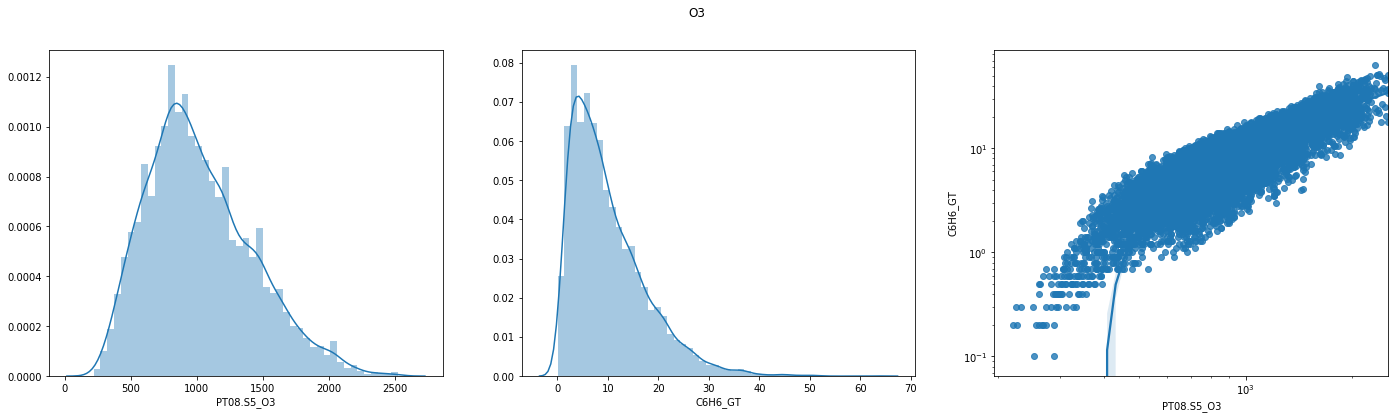

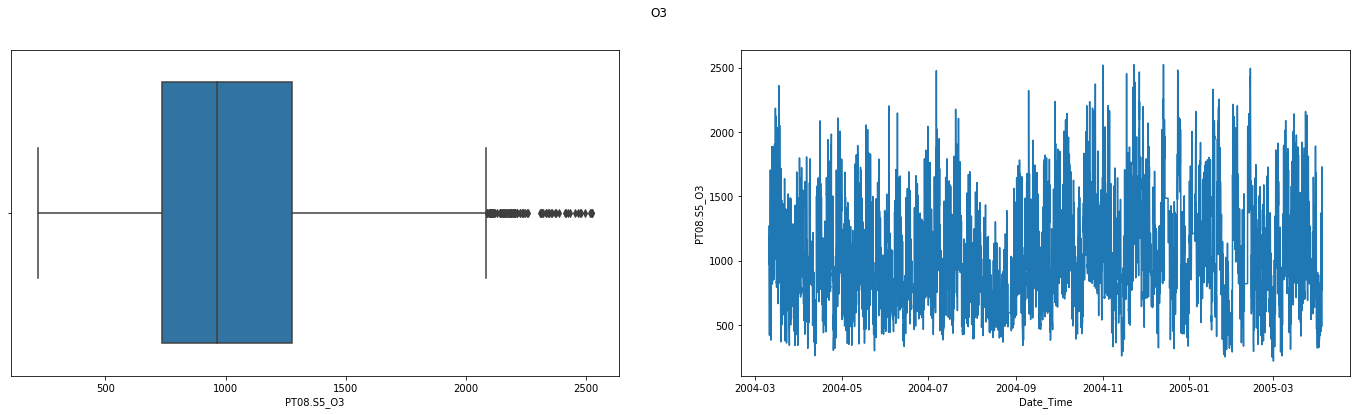

In [1028]:
# O3 data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
fig.suptitle('O3')
sns.distplot(df['PT08.S5_O3'], norm_hist=False, kde=True, ax=ax1) 
sns.distplot(df['C6H6_GT'], norm_hist=False, kde=True, ax=ax2)  
sns.regplot(x="PT08.S5_O3", y="C6H6_GT", data=df, ax=ax3)
ax3.set(xscale='log', yscale='log')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
fig.suptitle('O3')
sns.boxplot(x="PT08.S5_O3", data=df, ax=ax1)
sns.lineplot(x=df.index, y="PT08.S5_O3", data=df, ax=ax2)

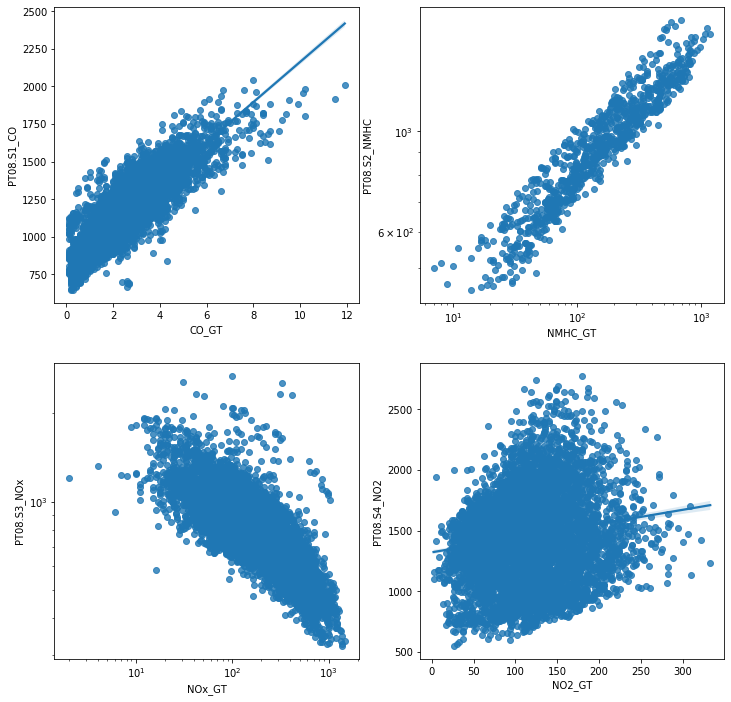

In [473]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(12, 12)

sns.regplot(x="CO_GT", y="PT08.S1_CO", data=df, ax=ax1)

sns.regplot(x="NMHC_GT", y="PT08.S2_NMHC", data=df, ax=ax2, fit_reg=False)
ax2.set(xscale='log', yscale='log')

sns.regplot(x="NOx_GT", y="PT08.S3_NOx", data=df, ax=ax3, fit_reg=False)
ax3.set(xscale='log', yscale='log')

sns.regplot(x="NO2_GT", y="PT08.S4_NO2", data=df, ax=ax4)



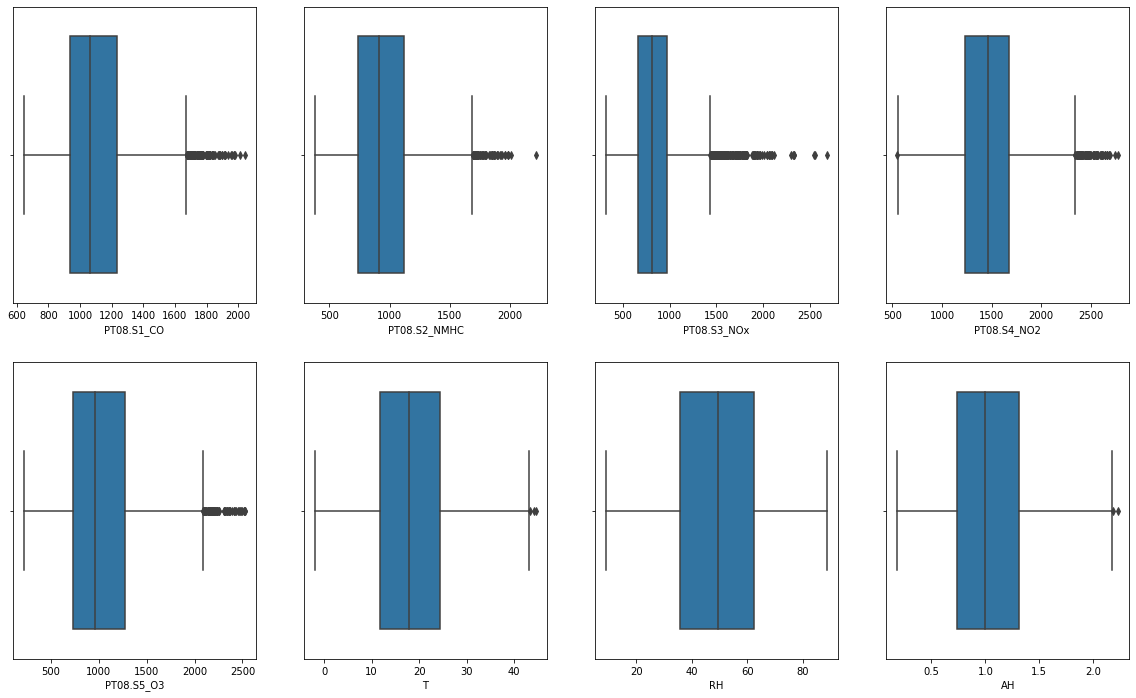

In [394]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4)
fig.set_size_inches(20, 12)
sns.boxplot(x="PT08.S1_CO", data=df, ax=ax1)
sns.boxplot(x="PT08.S2_NMHC", data=df, ax=ax2)
sns.boxplot(x="PT08.S3_NOx", data=df, ax=ax3)
sns.boxplot(x="PT08.S4_NO2", data=df, ax=ax4)
sns.boxplot(x="PT08.S5_O3", data=df, ax=ax5)
sns.boxplot(x="T", data=df, ax=ax6)
sns.boxplot(x="RH", data=df, ax=ax7)
sns.boxplot(x="AH", data=df, ax=ax8)


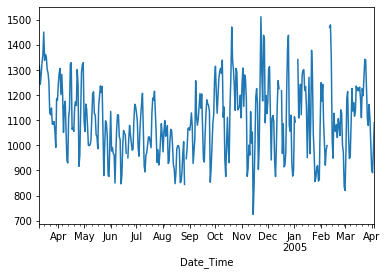

In [594]:
df['PT08.S1_CO'].resample('D').mean().plot()

In [397]:
df['Date']  = df.index
df_dow = df.groupby(df['Date'].dt.weekday).mean()

In [395]:
df2 = df.groupby(df['DT'].dt.weekday).mean()
df2

AttributeError: 'DatetimeIndex' object has no attribute 'dt'

KeyError: 'PT08.S1_NMHC'

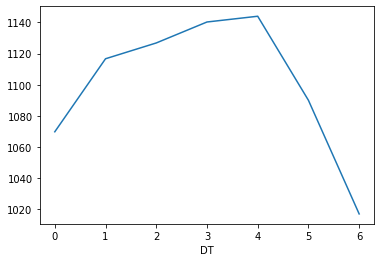

In [402]:
df2['PT08.S1_CO'].plot()
list_data = [df2['PT08.S1_CO'], df2['PT08.S1_NMHC']]
sns.lineplot(data=list_data)

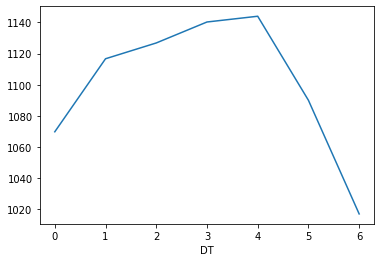

In [364]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6,)) = plt.subplots(2,3)
fig.set_size_inches(, 12)
sns.boxplot(x="PT08.S1_CO", data=df, ax=ax1)
sns.boxplot(x="PT08.S2_NMHC", data=df, ax=ax2)
sns.boxplot(x="PT08.S3_NOx", data=df, ax=ax3)
sns.boxplot(x="PT08.S4_NO2", data=df, ax=ax4)
sns.boxplot(x="PT08.S5_O3", data=df, ax=ax5)
sns.boxplot(x="T", data=df, ax=ax6)
sns.boxplot(x="RH", data=df, ax=ax7)
sns.boxplot(x="AH", data=df, ax=ax8)



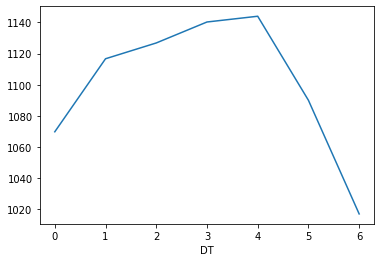

In [398]:
df2['PT08.S1_CO'].plot()

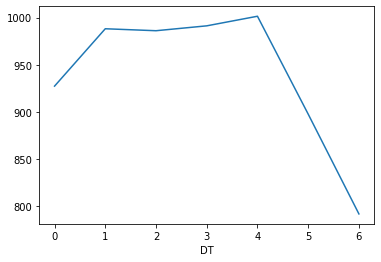

In [339]:
df2['PT08.S2_NMHC'].plot()

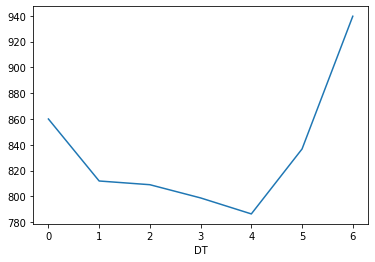

In [340]:
df2['PT08.S3_NOx'].plot()

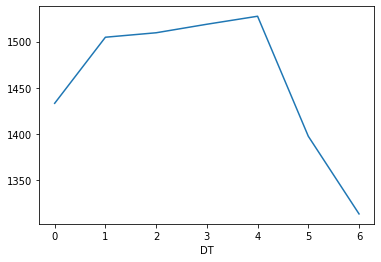

In [341]:
df2['PT08.S4_NO2'].plot()

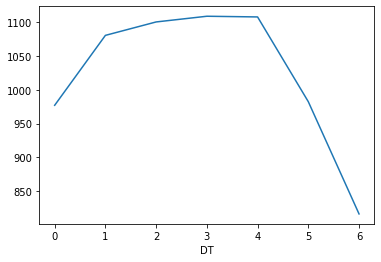

In [342]:
df2['PT08.S5_O3'].plot()

In [246]:
df['CO_GT'].describe()

count    7674.000000
mean        2.152750
std         1.453252
min         0.100000
25%         1.100000
50%         1.800000
75%         2.900000
max        11.900000
Name: CO_GT, dtype: float64

In [247]:
median = df['CO_GT'].describe()['50%']
median


1.8

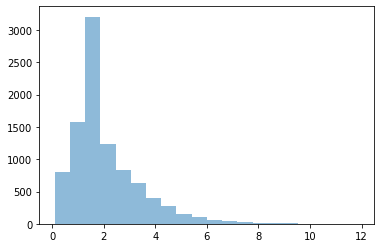

In [248]:
df['CO_GT'].fillna(median, inplace=True)
plt.hist(df['CO_GT'],  bins=20, alpha=0.5)
plt.show()

In [208]:
df['CO_GT'].describe()

count    9357.000000
mean        2.089302
std         1.323024
min         0.100000
25%         1.200000
50%         1.800000
75%         2.600000
max        11.900000
Name: CO_GT, dtype: float64

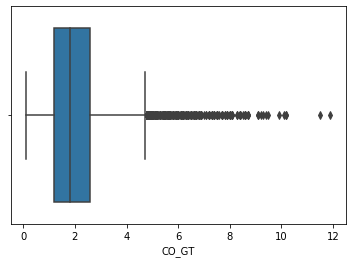

In [222]:
sns.boxplot(df['CO_GT'])

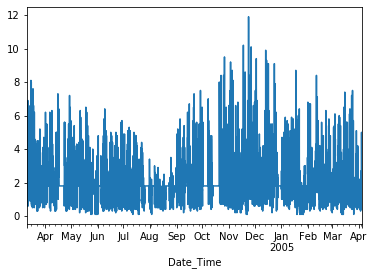

In [209]:
df['CO_GT'].plot()

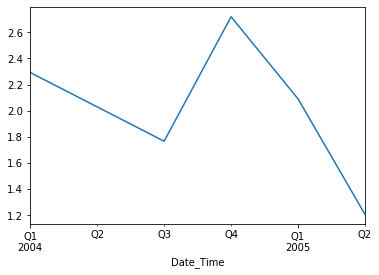

In [297]:
df['CO_GT'].resample('Q').mean().plot()

In [293]:
daily_avg = df['CO_GT'].resample('D').mean()
type(daily_avg)

pandas.core.series.Series

In [416]:
import pandas as pd
dff = pd.DataFrame({'date': ['2001-09-01', '2001-09-02', '2001-10-01', '2001-10-03', '2001-09-03'],
                   'value': [1, 2, 0, None, None]})
dff

,date,value
0,2001-09-01,1.0
1,2001-09-02,2.0
2,2001-10-01,0.0
3,2001-10-03,NaN
4,2001-09-03,NaN


In [417]:
dff.date = pd.to_datetime(df.date)
dff.fillna(dff.groupby([dff.date.dt.year, dff.date.dt.month]).transform('mean'), inplace=True)
dff

,date,value
0,2001-09-01,1.0
1,2001-09-02,2.0
2,2001-10-01,0.0
3,2001-10-03,0.0
4,2001-09-03,1.5


In [496]:
weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekdays[0]

day.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

'Monday'

In [631]:
d='2015-01-08 22:44:09' 
date=pd.to_datetime(df.index).date()
print(date)

TypeError: 'numpy.ndarray' object is not callable

In [602]:
import datetime as dt
pd.to_numeric(df.index.weekday).map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thr', 4: 'Fri', 5: 'Sat', 6: 'Sun'})

Index(['Wed', 'Wed', 'Wed', 'Wed', 'Wed', 'Wed', 'Thr', 'Thr', 'Thr', 'Thr',
       ...
       'Mon', 'Mon', 'Mon', 'Mon', 'Mon', 'Mon', 'Mon', 'Mon', 'Mon', 'Mon'],
      dtype='object', name='Date_Time', length=9357)

In [1059]:
# Day of the week 
df['DOW']  = df.index
df_dow = df.groupby(df['DOW'].dt.weekday).mean()
df_dow['Day'] = pd.to_numeric(df_dow.index).map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thr', 4: 'Fri', 5: 'Sat', 6: 'Sun'})

# Reorder columns
cols = df_dow.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_dow = df_dow[cols]

df_dow.reset_index(drop=True)
df_dow





,Day,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,NOx_GT,PT08.S3_NOx,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH
DOW,,,,,,,,,,,,,,
0,Mon,2.016741,1069.635334,180.110169,9.955641,925.136886,234.927872,858.862343,110.297683,1427.896351,980.614767,17.864437,47.744092,0.978723
1,Tue,2.382267,1115.669400,233.583333,11.680016,983.902237,267.667921,812.520884,117.393227,1492.385662,1083.136427,18.032874,48.703938,0.999615
2,Wed,2.400787,1127.953612,219.561151,11.400000,988.774594,270.430712,811.273605,120.007491,1495.644646,1107.768345,18.367902,49.630850,1.029290
3,Thr,2.455505,1135.592060,278.800000,11.526688,984.590729,282.604817,801.848435,120.843889,1503.271962,1103.809213,18.336667,50.074193,1.043231
4,Fri,2.543041,1145.264082,287.302469,11.729791,995.032453,284.506098,785.710742,123.452007,1514.871377,1115.917376,18.374307,50.786310,1.054830
5,Sat,1.861077,1088.358996,164.563636,8.507154,896.623835,224.491892,837.788856,107.567568,1398.554037,979.573932,18.268107,48.877326,1.014690
6,Sun,1.438069,1016.224490,99.114583,6.050873,792.767751,162.004608,939.069196,91.655300,1318.268601,816.564307,17.926276,49.185204,1.007587


In [1060]:
df_dow = df_dow.reset_index(drop=True)


In [1061]:
df_dow = df_dow.set_index('Day')
df_dow.reindex(['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun'])
df_dow

,CO_GT,PT08.S1_CO,NMHC_GT,C6H6_GT,PT08.S2_NMHC,NOx_GT,PT08.S3_NOx,NO2_GT,PT08.S4_NO2,PT08.S5_O3,T,RH,AH
Day,,,,,,,,,,,,,
Mon,2.016741,1069.635334,180.110169,9.955641,925.136886,234.927872,858.862343,110.297683,1427.896351,980.614767,17.864437,47.744092,0.978723
Tue,2.382267,1115.669400,233.583333,11.680016,983.902237,267.667921,812.520884,117.393227,1492.385662,1083.136427,18.032874,48.703938,0.999615
Wed,2.400787,1127.953612,219.561151,11.400000,988.774594,270.430712,811.273605,120.007491,1495.644646,1107.768345,18.367902,49.630850,1.029290
Thr,2.455505,1135.592060,278.800000,11.526688,984.590729,282.604817,801.848435,120.843889,1503.271962,1103.809213,18.336667,50.074193,1.043231
Fri,2.543041,1145.264082,287.302469,11.729791,995.032453,284.506098,785.710742,123.452007,1514.871377,1115.917376,18.374307,50.786310,1.054830
Sat,1.861077,1088.358996,164.563636,8.507154,896.623835,224.491892,837.788856,107.567568,1398.554037,979.573932,18.268107,48.877326,1.014690
Sun,1.438069,1016.224490,99.114583,6.050873,792.767751,162.004608,939.069196,91.655300,1318.268601,816.564307,17.926276,49.185204,1.007587


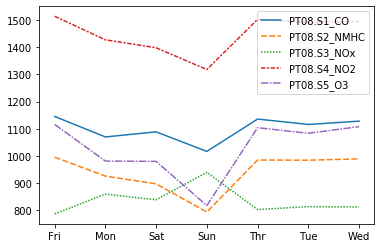

In [1062]:
list_data = [df_dow["PT08.S1_CO"], df_dow["PT08.S2_NMHC"], df_dow["PT08.S3_NOx"], df_dow["PT08.S4_NO2"], df_dow["PT08.S5_O3"]]
sns.lineplot(data=list_data)

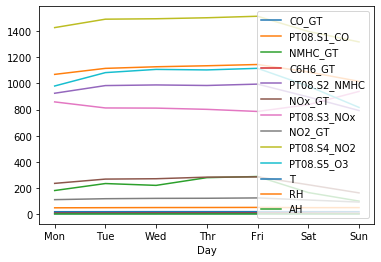

In [1064]:
df_dow.plot()